- [R Blog](https://blogs.rstudio.com/tensorflow/posts/2018-09-10-eager-style-transfer/)
- [Source Code](https://github.com/rstudio/keras/blob/master/vignettes/examples/eager_styletransfer.R)

In [2]:
#' This is the companion code to the post 
#' "Neural style transfer with eager execution and Keras"
#' on the TensorFlow for R blog.
#' 
#' https://blogs.rstudio.com/tensorflow/posts/2018-09-09-eager-style-transfer

library(keras)
use_implementation("tensorflow")
use_session_with_seed(7777, disable_gpu = FALSE, disable_parallel_cpu = FALSE)
library(tensorflow)
# tfe_enable_eager_execution(device_policy = "silent")

library(purrr)
library(glue)

Set session seed to 7777


In [11]:
img_shape <- c(800, 600, 3)
image_dir <- 'D:/Program_files/Projects/data-science-learning-resource/python-notebooks/data'
style_dir <- 'D:/art collections'
content_path <- paste0(image_dir, '/pantherchameleon1.jpg')
style_path <- paste0(style_dir, '/The Combat of the Giaour and Hassan.jpg')


num_iterations <- 100
content_weight <- 100
style_weight <- 0.8
total_variation_weight <- 0.01

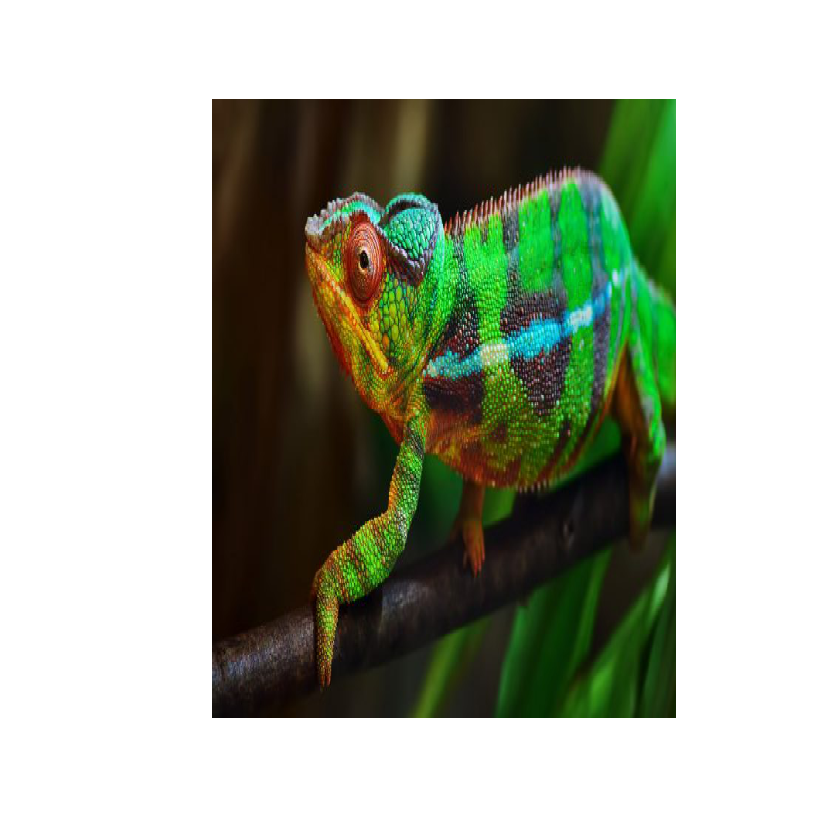

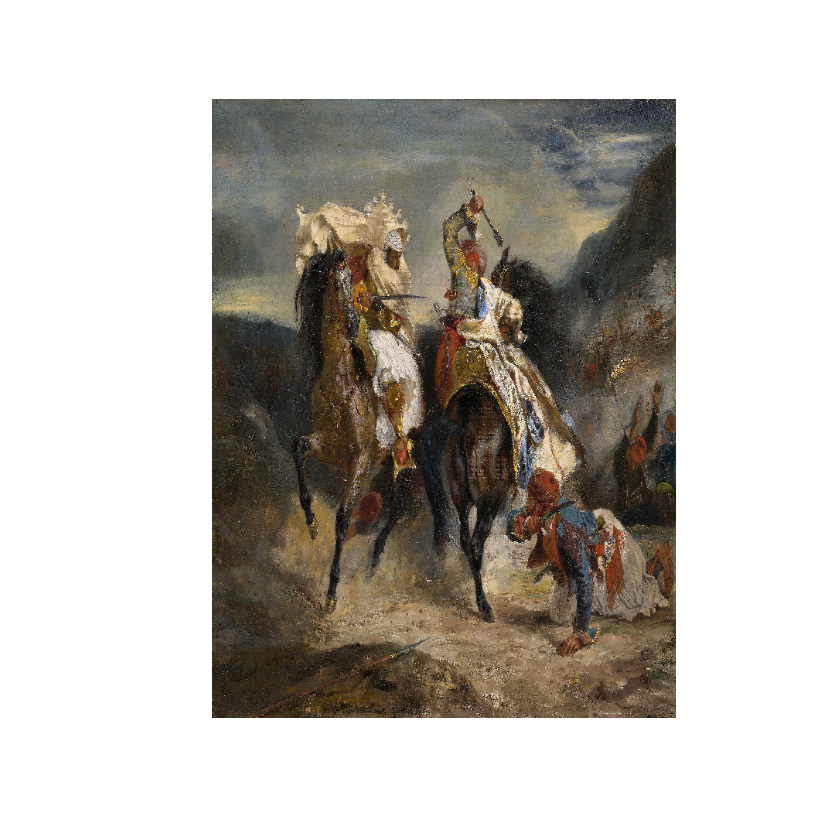

In [12]:
content_image <- image_load(content_path, target_size = img_shape[1:2])
content_image %>% 
    image_to_array() %>%
    `/`(., 255) %>%
    as.raster() %>%  
    plot()

style_image <- image_load(style_path, target_size = img_shape[1:2])
style_image %>% 
    image_to_array() %>%
    `/`(., 255) %>%
    as.raster() %>%  
    plot()

In [13]:
load_and_process_image <- function(path) {
  img <- image_load(path, target_size = img_shape[1:2]) %>%
    image_to_array() %>%
    k_expand_dims(axis = 1) %>%
    imagenet_preprocess_input()
}

deprocess_image <- function(x) {
  x <- x[1, , ,]
  # Remove zero-center by mean pixel
  x[, , 1] <- x[, , 1] + 103.939
  x[, , 2] <- x[, , 2] + 116.779
  x[, , 3] <- x[, , 3] + 123.68
  # 'BGR'->'RGB'
  x <- x[, , c(3, 2, 1)]
  x[x > 255] <- 255
  x[x < 0] <- 0
  x[] <- as.integer(x) / 255
  x
}

In [14]:
content_layers <- c("block5_conv2")
style_layers = c("block1_conv1",
                 "block2_conv1",
                 "block3_conv1",
                 "block4_conv1",
                 "block5_conv1")
num_content_layers <- length(content_layers)
num_style_layers <- length(style_layers)

In [17]:
get_model <- function() {
  vgg <- application_vgg19(include_top = FALSE, weights = "imagenet")
  vgg$trainable <- FALSE
  style_outputs <-
    map(style_layers, function(layer)
      vgg$get_layer(layer)$output)
  content_outputs <-
    map(content_layers, function(layer)
      vgg$get_layer(layer)$output)
  model_outputs <- c(style_outputs, content_outputs)
  keras_model(vgg$input, model_outputs)
}

content_loss <- function(content_image, target) {
  k_sum(k_square(target - content_image))
}

gram_matrix <- function(x) {
  features <- k_batch_flatten(k_permute_dimensions(x, c(3, 1, 2)))
  gram <- k_dot(features, k_transpose(features))
  gram
}

style_loss <- function(gram_target, combination) {
  gram_comb <- gram_matrix(combination)
  k_sum(k_square(gram_target - gram_comb)) / (4 * (img_shape[3] ^ 2) * (img_shape[1] * img_shape[2]) ^
                                                2)
}

total_variation_loss <- function(image) {
  y_ij  <- image[1:(img_shape[1] - 1L), 1:(img_shape[2] - 1L),]
  y_i1j <- image[2:(img_shape[1]), 1:(img_shape[2] - 1L),]
  y_ij1 <- image[1:(img_shape[1] - 1L), 2:(img_shape[2]),]
  a <- k_square(y_ij - y_i1j)
  b <- k_square(y_ij - y_ij1)
  k_sum(k_pow(a + b, 1.25))
}

get_feature_representations <-
  function(model, content_path, style_path) {
    # dim == (1, 128, 128, 3)
    style_image <- load_and_process_image(style_path) %>% k_cast("float32")
    # dim == (1, 128, 128, 3)
    content_image <- load_and_process_image(content_path) %>% k_cast("float32")
    # dim == (2, 128, 128, 3)
    stack_images <- k_concatenate(list(style_image, content_image), axis = 1)
    # length(model_outputs) == 6
    # dim(model_outputs[[1]]) = (2, 128, 128, 64)
    # dim(model_outputs[[6]]) = (2, 8, 8, 512)
    model_outputs <- model(stack_images)
    
    style_features <- model_outputs[1:num_style_layers] %>% 
                      map(function(batch) batch[1, , , ])
    
    content_features <-
      model_outputs[(num_style_layers + 1):(num_style_layers + num_content_layers)] %>%
      map(function(batch) batch[2, , , ])
    
    list(style_features, content_features)
  }

compute_loss <-
  function(model, loss_weights, init_image, gram_style_features, content_features) {
    c(style_weight, content_weight) %<-% loss_weights
    model_outputs <- model(init_image)
    style_output_features <- model_outputs[1:num_style_layers]
    content_output_features <- model_outputs[(num_style_layers + 1):(num_style_layers + num_content_layers)]
    
    weight_per_style_layer <- 1 / num_style_layers
    style_score <- 0
    # str(style_zip, max.level = 1)
    # dim(style_zip[[5]][[1]]) == (512, 512)
    style_zip <- transpose(list(gram_style_features, style_output_features))
    
    for (l in 1:length(style_zip)) {
      # for l == 1:
      # dim(target_style) == (64, 64)
      # dim(comb_style) == (1, 128, 128, 64)
      c(target_style, comb_style) %<-% style_zip[[l]]
      style_score <-
        style_score + weight_per_style_layer * style_loss(target_style, comb_style[1, , , ])
    }
    
    weight_per_content_layer <- 1 / num_content_layers
    content_score <- 0
    content_zip <- transpose(list(content_features, content_output_features))
    
    for (l in 1:length(content_zip)) {
      # dim(comb_content) ==  (1, 8, 8, 512)
      # dim(target_content) == (8, 8, 512)
      c(target_content, comb_content) %<-% content_zip[[l]]
      content_score <- content_score + weight_per_content_layer * content_loss(comb_content[1, , , ], target_content)
    }
    
    variation_loss <- total_variation_loss(init_image[1, , ,])
    style_score <- style_score * style_weight
    content_score <- content_score * content_weight
    variation_score <- variation_loss * total_variation_weight
    
    loss <- style_score + content_score + variation_score
    list(loss, style_score, content_score, variation_score)
  }

compute_grads <- function(model, loss_weights, init_image, gram_style_features, content_features) {
    with(tf$GradientTape() %as% tape, {
      scores <-
        compute_loss(model,
                     loss_weights,
                     init_image,
                     gram_style_features,
                     content_features)
    })
    total_loss <- scores[[1]]
    list(tape$gradient(total_loss, init_image), scores)
  }

run_style_transfer <- function(content_path, style_path) {
  model <- get_model()
  walk(model$layers, function(layer)
    layer$trainable = FALSE)
  
  c(style_features, content_features) %<-% get_feature_representations(model, content_path, style_path)
  # dim(gram_style_features[[1]]) == (64, 64)
  # we compute this once, in advance
  gram_style_features <-
    map(style_features, function(feature)
      gram_matrix(feature))
  
  init_image <- load_and_process_image(content_path)
  init_image <- tf$contrib$eager$Variable(init_image, dtype = "float32")
  
  optimizer <- tf$train$AdamOptimizer(learning_rate = 1, beta1 = 0.99, epsilon = 1e-1)
  
  c(best_loss, best_image) %<-% list(Inf, NULL)
  loss_weights <- list(style_weight, content_weight)
  
  start_time <- Sys.time()
  global_start <- Sys.time()
  
  norm_means <- c(103.939, 116.779, 123.68)
  min_vals <- -norm_means
  max_vals <- 255 - norm_means
  
  for (i in seq_len(num_iterations)) {
    # dim(grads) == (1, 128, 128, 3)
    c(grads, all_losses) %<-% compute_grads(model,
                                            loss_weights,
                                            init_image,
                                            gram_style_features,
                                            content_features)
    c(loss, style_score, content_score, variation_score) %<-% all_losses
    optimizer$apply_gradients(list(tuple(grads, init_image)))
    clipped <- tf$clip_by_value(init_image, min_vals, max_vals)
    init_image$assign(clipped)
    
    end_time <- Sys.time()
    
    if (k_cast_to_floatx(loss) < best_loss) {
      best_loss <- k_cast_to_floatx(loss)
      best_image <- init_image
    }
    
    if (i %% 50 == 0) {
      glue("Iteration: {i}") %>% print()
      glue(
        "Total loss: {k_cast_to_floatx(loss)}, style loss: {k_cast_to_floatx(style_score)},
        content loss: {k_cast_to_floatx(content_score)}, total variation loss: {k_cast_to_floatx(variation_score)},
        time for 1 iteration: {(Sys.time() - start_time) %>% round(2)}"
      ) %>% print()
      
      if (i %% 100 == 0) {
        png(paste0("style_epoch_", i, ".png"))
        plot_image <- best_image$numpy()
        plot_image <- deprocess_image(plot_image)
        plot(as.raster(plot_image), main = glue("Iteration {i}"))
        dev.off()
      }
    }
  }
  
  glue("Total time: {Sys.time() - global_start} seconds") %>% print()
  list(best_image, best_loss)
}

In [18]:
c(best_image, best_loss) %<-% run_style_transfer(content_path, style_path)

ERROR: Error in dim(x) <- length(x): invalid first argument
